In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec

## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,276,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,264,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,287,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,264,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 37): [1051], (0, 21, 55): [1612], (0, 21, 57): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

C:\Users\Kalea\AppData\Local\Temp\ipykernel_7260\635274658.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3273
klasifikasi_perkara_encoded
0    1378
2    1251
3     289
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1050
klasifikasi_perkara_encoded
0    490
2    438
4     51
3     48
1     23
Name: count, dtype: int64


## Model

### Model Preprocessing

In [9]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [10]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [11]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [12]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(remove_stopwords)
test_df['stopword_removal'] = test_df['normalized_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Stemming

In [13]:
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train_df['stemmed_text'] = train_df['stopword_removal'].apply(stem_text)
test_df['stemmed_text'] = test_df['stopword_removal'].apply(stem_text)

### Tokenizer

In [14]:
# Tokenisasi
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(train_df['stemmed_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['stemmed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['stemmed_text'])

In [15]:
vocab_size = len(tokenizer.word_index) + 1  # 4 + 1 = 5
print("Vocabulary size:", vocab_size)

Vocabulary size: 14906


In [16]:
# Padding
# max_len = max(len(seq) for seq in train_sequences)
max_len = 1024
X_train_texts = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_texts = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [17]:
print(max_len)

1024


### Numerical Features

In [18]:
# TANPA LOG TRANSFORM (gunakan salah satu)

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values, dtype=tf.float32)

## Saved Model Inference

In [27]:
model_scenario_name = "BiLSTM_13"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
# loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [20]:
# Buat model embedding: token integer -> embedding float
input_text_new = tf.keras.Input(shape=(1024,), dtype=tf.int32, name='text_input_new')
embedding_layer = loaded_model.get_layer('embedding')
embedding_output = embedding_layer(input_text_new)
embedding_model = tf.keras.Model(inputs=input_text_new, outputs=embedding_output)

# Buat input baru: embedding dan numeric
input_embed = tf.keras.Input(shape=(1024, 256), name='embedding_input')
input_num = tf.keras.Input(shape=(5,), name='numeric_input')

# Rekonstruksi bagian setelah embedding
x = loaded_model.get_layer('bidirectional')(input_embed)
x = loaded_model.get_layer('batch_normalization')(x)
x = loaded_model.get_layer('bidirectional_1')(x)
x = loaded_model.get_layer('batch_normalization_1')(x)
x = loaded_model.get_layer('bidirectional_2')(x)
x = loaded_model.get_layer('batch_normalization_2')(x)
x = loaded_model.get_layer('global_max_pooling1d')(x)
x = loaded_model.get_layer('dropout')(x)

n = loaded_model.get_layer('batch_normalization_3')(input_num)
n = loaded_model.get_layer('dense')(n)
n = loaded_model.get_layer('dense_1')(n)
n = loaded_model.get_layer('dense_2')(n)

concat = loaded_model.get_layer('concatenate')([x, n])
concat = loaded_model.get_layer('batch_normalization_4')(concat)
concat = loaded_model.get_layer('dense_3')(concat)
concat = loaded_model.get_layer('dropout_1')(concat)
concat = loaded_model.get_layer('dense_4')(concat)
output = loaded_model.get_layer('dense_5')(concat)

# Final model: menerima embedding float dan numeric float
new_model = tf.keras.Model(inputs=[input_embed, input_num], outputs=output)


In [ ]:

# Fungsi integrated gradients
def integrated_gradients_embedding(model, embedding_input, numeric_input, baseline_embed=None, baseline_num=None, m_steps=50):
    if baseline_embed is None:
        baseline_embed = tf.zeros_like(embedding_input)
    if baseline_num is None:
        baseline_num = tf.zeros_like(numeric_input)

    delta_embed = embedding_input - baseline_embed
    delta_num = numeric_input - baseline_num

    total_grads_embed = tf.zeros_like(embedding_input, dtype=tf.float32)
    total_grads_num = tf.zeros_like(numeric_input, dtype=tf.float32)

    alphas = tf.linspace(0.0, 1.0, m_steps)

    for alpha in alphas:
        interpolated_embed = baseline_embed + alpha * delta_embed
        interpolated_num = baseline_num + alpha * delta_num

        with tf.GradientTape() as tape:
            tape.watch([interpolated_embed, interpolated_num])
            preds = model([interpolated_embed, interpolated_num], training=False)

        grads = tape.gradient(preds, [interpolated_embed, interpolated_num])

        total_grads_embed += grads[0]
        total_grads_num += grads[1]

    avg_grads_embed = total_grads_embed / tf.cast(m_steps, tf.float32)
    avg_grads_num = total_grads_num / tf.cast(m_steps, tf.float32)

    integrated_grad_embed = delta_embed * avg_grads_embed
    integrated_grad_num = delta_num * avg_grads_num

    return integrated_grad_embed, integrated_grad_num

In [26]:
integrated_gradient_results = {}

In [27]:

for i in tqdm(range(len(X_test_texts))):
    sample_text_int = tf.constant([X_test_texts[i]], dtype=tf.int32)
    embedding_float = embedding_model(sample_text_int)
    
    numeric_tensor = tf.reshape(test_numerical[i], (1, 5))

    ig_text, ig_numeric = integrated_gradients_embedding(new_model, embedding_float, numeric_tensor)

    if 'ig_text' not in integrated_gradient_results:
        integrated_gradient_results['ig_text'] = []

    if 'ig_numeric' not in integrated_gradient_results:
        integrated_gradient_results['ig_numeric'] = []

    integrated_gradient_results['ig_text'].append(ig_text)
    integrated_gradient_results['ig_numeric'].append(ig_numeric)


100%|██████████| 1050/1050 [3:22:08<00:00, 11.55s/it] 


In [28]:
integrated_gradient_results['ig_text'][0]

<tf.Tensor: shape=(1, 1024, 256), dtype=float32, numpy=
array([[[-0.00170077, -0.00855211, -0.00414075, ..., -0.00969422,
         -0.02039644, -0.00937904],
        [-0.00221879,  0.00840896, -0.00421031, ..., -0.02745531,
         -0.01810046, -0.00128494],
        [ 0.00038716,  0.00125626, -0.00423062, ...,  0.03831901,
         -0.00394504,  0.02057048],
        ...,
        [-0.06187845, -0.00905786, -0.01349937, ...,  0.00080216,
         -0.00968476, -0.00711572],
        [-0.05998296, -0.00975306, -0.01909804, ...,  0.00190685,
         -0.01366026, -0.01014192],
        [-0.04557592, -0.01104334, -0.01590293, ...,  0.00585538,
         -0.01516594, -0.01475155]]], dtype=float32)>

In [ ]:
# Simpan ke file
with open('integrated_gradient_results.pkl', 'wb') as f:
    pickle.dump(integrated_gradient_results, f)



In [ ]:
# Load File
with open('integrated_gradient_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

In [3]:
loaded_results['ig_numeric']

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.       , 0.       , 0.       , 1.5012991, 1.7499776]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.0000000e+00,  7.5903907e-04,  0.0000000e+00,  1.7256484e+00,
          3.8550782e-01]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.0000000e+00, -1.6281646e-04,  1.5510552e-02,  9.4895566e-01,
          4.8615355e+00]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        ,  0.05245126, -0.        ,  1.0658554 , 10.785488  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        ,  0.05855698, -0.        ,  1.1008494 , 10.790839  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.        ,  0.02102938, -0.01084582,  1.3032999 ,  3.441144  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.        , 0.00501573, 

In [4]:
ig_numeric = loaded_results['ig_numeric']

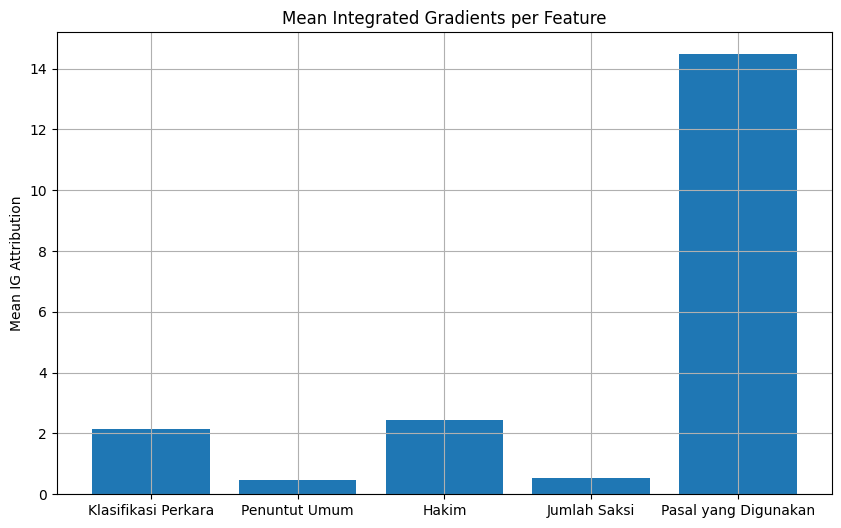

In [15]:
ig_array_numeric = np.array(ig_numeric)
mean_ig_numeric = np.mean(ig_array_numeric, axis=0)
mean_ig_numeric = np.squeeze(mean_ig_numeric)
mean_ig_numeric = mean_ig_numeric.astype(float)

plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_ig_numeric)), mean_ig_numeric)
plt.xticks(range(len(mean_ig_numeric)), ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan'])
plt.ylabel('Mean IG Attribution')
plt.title('Mean Integrated Gradients per Feature')
plt.grid(True)

plt.show()

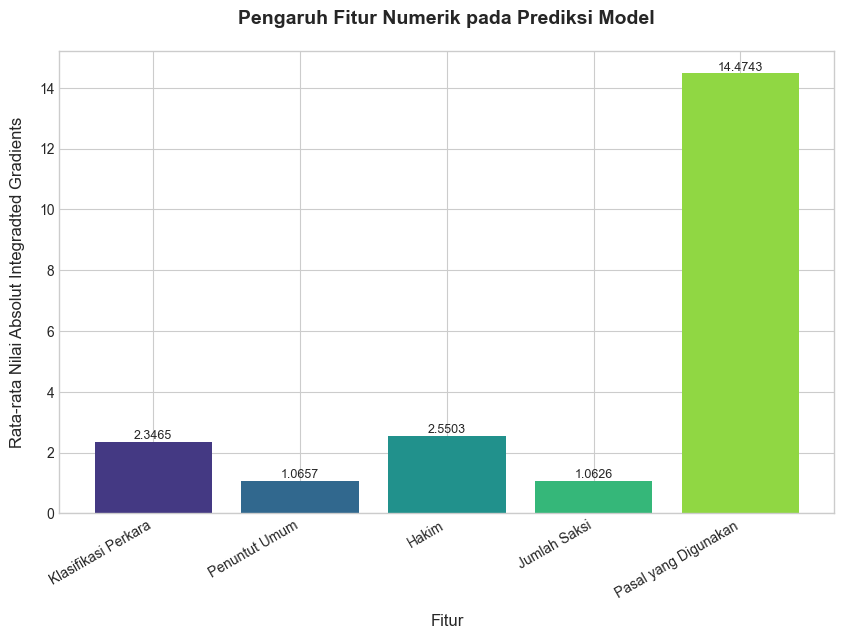

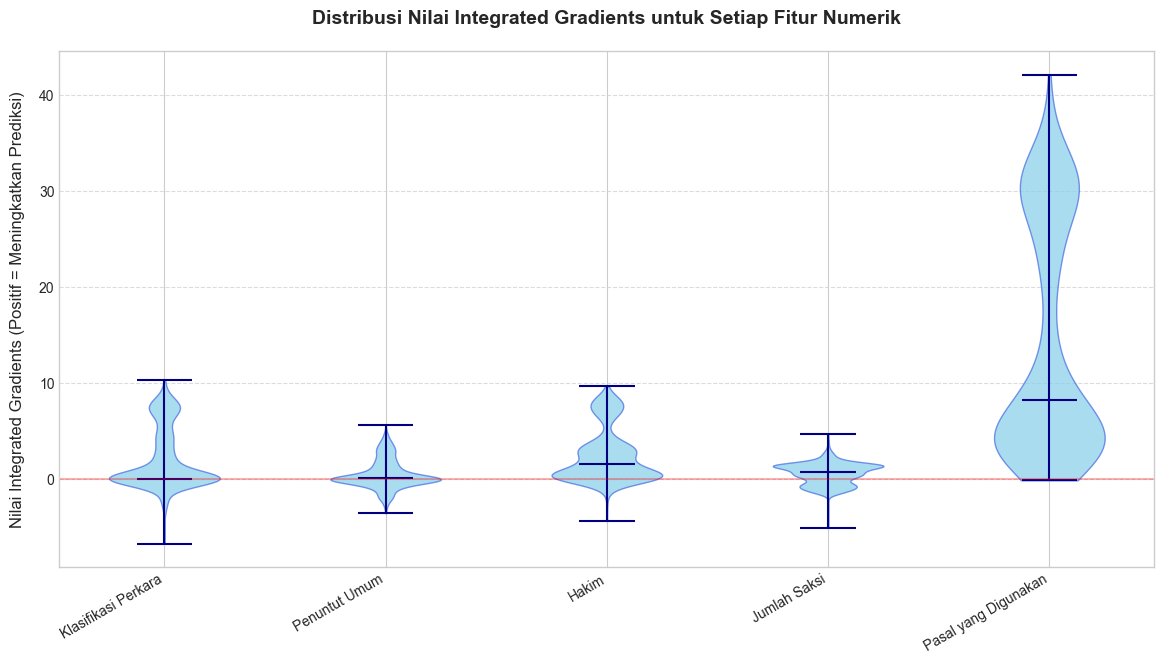

In [61]:

# ig_array_numeric = np.array(ig_numeric)
# mean_ig_numeric = np.mean(ig_array_numeric, axis=0)
# mean_ig_numeric = np.squeeze(mean_ig_numeric)
# mean_ig_numeric = mean_ig_numeric.astype(float)

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(mean_ig_numeric)), mean_ig_numeric)
# plt.xticks(range(len(mean_ig_numeric)), ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan'])
# plt.ylabel('Mean IG Attribution')
# plt.title('Mean Integrated Gradients per Feature')
# plt.grid(True)

# plt.show()

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Konfigurasi font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Fitur numerik
# Proses Data Numerik
ig_array_numeric = np.array(ig_numeric)
mean_ig_numeric = np.mean(np.abs(ig_array_numeric), axis=0)
mean_ig_numeric = np.squeeze(mean_ig_numeric)
mean_ig_numeric = mean_ig_numeric.astype(float)

# Nama fitur numerik
feature_names_num = ['Klasifikasi Perkara', 'Penuntut Umum', 'Hakim', 'Jumlah Saksi', 'Pasal yang Digunakan']

# warna gradien
colors = sns.color_palette("viridis", len(feature_names_num))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(mean_ig_numeric)), mean_ig_numeric, color=colors)

# nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xticks(range(len(mean_ig_numeric)))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Pengaruh Fitur Numerik pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Fitur', labelpad=10)
ax.set_ylabel('Rata-rata Nilai Absolut Integradted Gradients', labelpad=10)

# # anotasi dan grid
# ax.annotate('Fitur dengan nilai IG lebih tinggi memiliki pengaruh lebih besar pada prediksi model', 
#             xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10, fontstyle='italic')
# ax.grid(axis='y', linestyle='--', alpha=0.7)
# fig.tight_layout(pad=2)
plt.show()

# plot violin
ig_array_violin = np.squeeze(ig_array_numeric)

fig, ax = plt.subplots(figsize=(12, 7))
data_to_plot = []
for i in range(ig_array_violin.shape[1]):
    data_to_plot.append(ig_array_violin[:, i])

violin_parts = ax.violinplot(data_to_plot, showmedians=True)

# Kustomisasi violin plot
for pc in violin_parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.7)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    vp = violin_parts[partname]
    vp.set_edgecolor('navy')
    vp.set_linewidth(1.5)

ax.set_xticks(range(1, len(feature_names_num) + 1))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Distribusi Nilai Integrated Gradients untuk Setiap Fitur Numerik', fontweight='bold', pad=20)
ax.set_ylabel('Nilai Integrated Gradients (Positif = Meningkatkan Prediksi)', labelpad=10)
ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout(pad=2)
plt.show()

In [23]:
ig_array_token = loaded_results['ig_text']

In [24]:
np.shape(ig_array_token)

(1050, 1, 1024, 256)

In [25]:
ig_array_reshaped = np.squeeze(ig_array_token, axis=1)
np.shape(ig_array_reshaped)

(1050, 1024, 256)


 Semua Sampel - 20 TOKEN PALING BERPENGARUH 
TOKEN ID   KATA                 NILAI ATTRIBUTIONS
------------------------------------------------------------
1023       termin               0.00900
1022       menggunakannya       0.00856
1021       ud                   0.00849
1020       isap                 0.00821
1019       dikirimkan           0.00784
1018       kode                 0.00736
1017       andr                 0.00679
1016       rincian              0.00617
1015       kangin               0.00555
1014       menderita            0.00500
1007       tangga               0.00476
1008       permintaan           0.00475
1009       makanan              0.00473
1006       rekannya             0.00473
1010       bu                   0.00467
1005       pand                 0.00464
1013       berperan             0.00463
1011       sanjaya              0.00454
1012       tiang                0.00449
1004       menjanjikan          0.00449



C:\Users\Kalea\AppData\Local\Temp\ipykernel_17368\4048781532.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma')


(<Figure size 1400x1000 with 2 Axes>,
 <Axes: title={'center': 'Semua Sampel: 20 Token dengan Pengaruh Terbesar pada Prediksi Model'}, xlabel='Rata-rata |Attribution|', ylabel='Token'>)

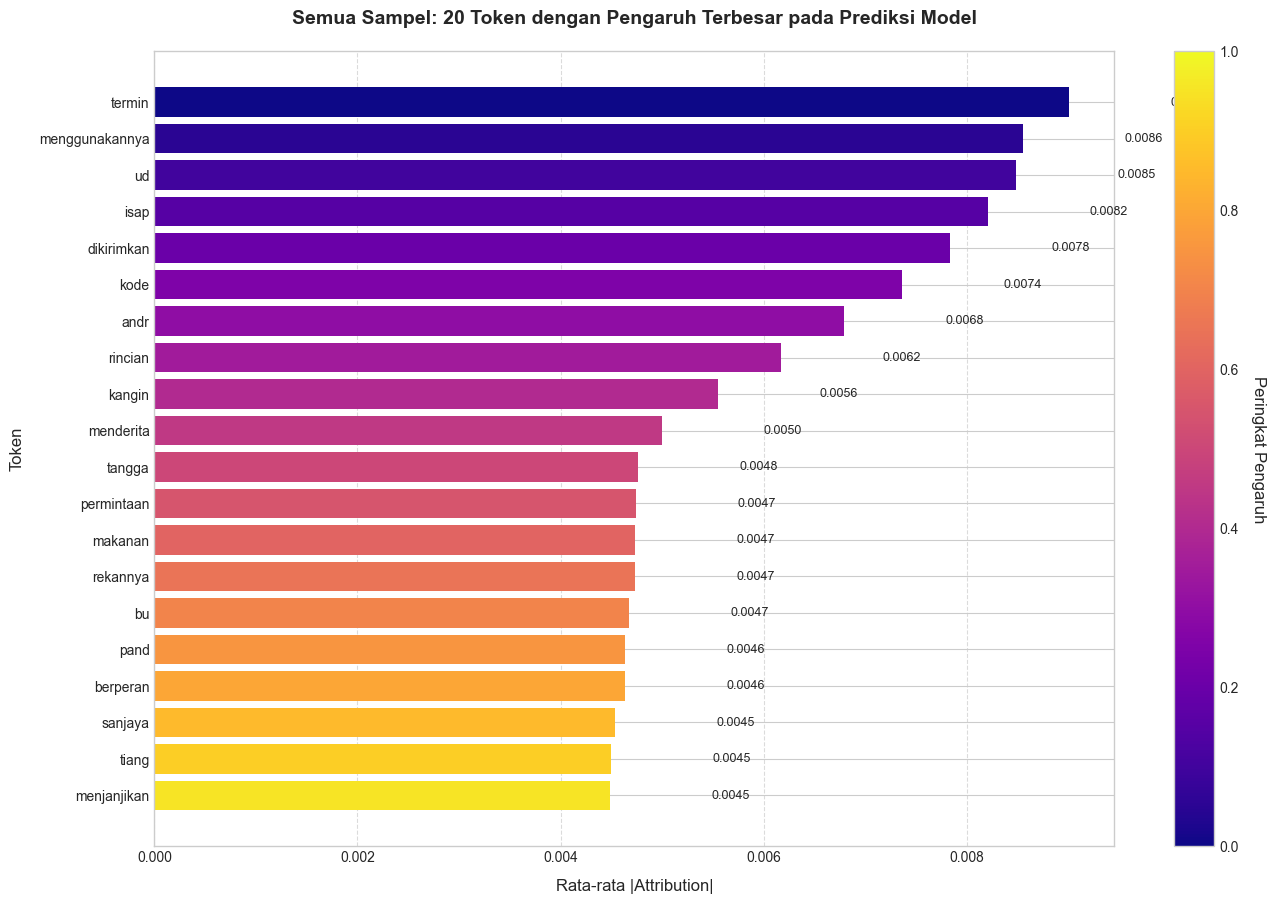

In [56]:
def visualize_token_importance(ig_array, tokenizer, n_top=10, sample_idx=None):
    if sample_idx is not None:
        ig_data = ig_array[sample_idx]
        title_prefix = f"Sampel #{sample_idx}"
    else:
        # Ambil rata-rata semua sampel
        ig_data = np.mean(ig_array, axis=0)
        title_prefix = "Semua Sampel"
    
    token_contributions = np.mean(np.abs(ig_data), axis=-1)  # shape (n_tokens,)
    
    # Ambil token teratas
    top_idx = np.argsort(token_contributions)[-n_top:][::-1]
    top_values = token_contributions[top_idx]
    
    # Decode token ID ke kata
    index_word = tokenizer.index_word
    top_tokens = [index_word.get(i, "[UNK]") for i in top_idx]
    
    # Cetak hasil
    print("\n" + "="*60)
    print(f" {title_prefix} - {n_top} TOKEN PALING BERPENGARUH ")
    print("="*60)
    print(f"{'TOKEN ID':<10} {'KATA':<20} {'NILAI ATTRIBUTIONS':<15}")
    print("-"*60)
    for idx, token, val in zip(top_idx, top_tokens, top_values):
        print(f"{idx:<10} {token:<20} {val:.5f}")
    print("="*60 + "\n")
    
    # colormap
    cmap = plt.cm.get_cmap('plasma')
    colors = [cmap(i/len(top_tokens)) for i in range(len(top_tokens))]
    
    # horizontal bar
    fig, ax = plt.subplots(figsize=(14, 10))
    bars = ax.barh(range(len(top_tokens)), top_values, color=colors)
    
    # nilai pada bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=9)
    
    # sumbu y
    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.invert_yaxis()
    
    # colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Peringkat Pengaruh', rotation=270, labelpad=20)
    
    # judul dan label
    ax.set_title(f'{title_prefix}: {n_top} Token dengan Pengaruh Terbesar pada Prediksi Model', 
                 fontweight='bold', pad=20)
    ax.set_xlabel('Rata-rata |Attribution|', labelpad=10)
    ax.set_ylabel('Token', labelpad=10)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.97], pad=2)
    return fig, ax

def visualize_interactive(ig_array, tokenizer, n_samples_to_show=5, n_top=10):
    n_samples = ig_array.shape[0]
    n_samples_to_show = min(n_samples_to_show, n_samples)
    
    fig = plt.figure(figsize=(20, 24))
    gs = gridspec.GridSpec(n_samples_to_show + 1, 1, height_ratios=[3] + [2] * n_samples_to_show)
    
    # Plot agregasi semua sampel
    ax_all = plt.subplot(gs[0])
    visualize_single_plot(ig_array, tokenizer, n_top, None, ax_all, "Semua Sampel (Rata-rata)")
    
    # Plot sampel individual
    sample_indices = np.linspace(0, n_samples-1, n_samples_to_show, dtype=int)
    for i, sample_idx in enumerate(sample_indices):
        ax = plt.subplot(gs[i+1])
        visualize_single_plot(ig_array, tokenizer, n_top, sample_idx, ax, f"Sampel #{sample_idx}")
    
    plt.tight_layout()
    return fig

def visualize_single_plot(ig_array, tokenizer, n_top, sample_idx, ax, title_prefix):
    if sample_idx is not None:
        ig_data = ig_array[sample_idx]  # shape (n_tokens, embedding_dim)

    else:
        ig_data = np.mean(ig_array, axis=0)  # shape (n_tokens, embedding_dim)
    
    # Hitung skor kontribusi per token
    token_contributions = np.mean(np.abs(ig_data), axis=-1)  # shape (n_tokens,)
    
    # Ambil token teratas
    top_idx = np.argsort(token_contributions)[-n_top:][::-1]
    top_values = token_contributions[top_idx]
    
    # Decode token ID ke kata
    index_word = tokenizer.index_word
    top_tokens = [index_word.get(i, "[UNK]") for i in top_idx]
    
    # colormap
    cmap = plt.cm.get_cmap('plasma')
    colors = [cmap(i/len(top_tokens)) for i in range(len(top_tokens))]
    
    # horizontal bar
    bars = ax.barh(range(len(top_tokens)), top_values, color=colors)
    
    # nilai pada bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=9)
    
    # sumbu y
    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.invert_yaxis()
    
    # judul dan label
    ax.set_title(f'{title_prefix}: {n_top} Token Teratas', fontweight='bold')
    ax.set_xlabel('Rata-rata |Attribution|', labelpad=5)
    ax.set_ylabel('Token', labelpad=5)
    ax.grid(axis='x', linestyle='--', alpha=0.7)

visualize_token_importance(ig_array_reshaped, tokenizer, n_top=20)  # Visualisasi rata-rata semua sampel
# visualize_token_importance(ig_array_reshaped, tokenizer, n_top=10, sample_idx=77)  # Visualisasi salah satu sampel 
# visualize_interactive(ig_array_reshaped, tokenizer)  # Visualisasi interaktif

# fig, ax = visualize_token_importance(ig_array_reshaped, tokenizer)
# plt.show()

# fig = visualize_interactive(ig_array_reshaped, tokenizer)
# plt.show()